In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from explainers_lib.explainers.native.growing_spheres import GrowingSpheresExplainer
from explainers_lib.model import Model as ExplainerModel
import explainers_lib.model
from explainers_lib.datasets import Dataset

from explainers_lib.explainers.native.wachter import WachterExplainer
from explainers_lib.explainers.native.face import FaceExplainer as NativeFaceExplainer
from explainers_lib.explainers.native.growing_spheres import GrowingSpheresExplainer

from explainers_lib.explainers.celery_explainer import ActionableRecourseExplainer
from explainers_lib.explainers.celery_explainer import FaceExplainer
from explainers_lib.explainers.celery_explainer import DiceExplainer
from explainers_lib.explainers.celery_explainer import AlibiCFProto
from explainers_lib.explainers.celery_explainer import AlibiCFRL

from explainers_lib.aggregators import Pareto, All
from explainers_lib.datasets import Dataset
from explainers_lib.ensemble import Ensemble


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [21]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class TransConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(1, 64),   # 32 -> 16
            ConvBlock(64, 128),  # 16 -> 8
            ConvBlock(128, 256), # 8 -> 4
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, latent_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            TransConvBlock(256, 128),   # 4 -> 8
            TransConvBlock(128, 64),    # 8 -> 16
            TransConvBlock(64, 32),     # 16 -> 32
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 4, 4)
        x = self.decoder(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [22]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        flatten_dim = 64 * 8 * 8

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [23]:
autoencoder = Autoencoder(latent_dim=32).to(device)
autoencoder.load_state_dict(torch.load('models/torch_ae_mnist_paper.pth', map_location=device))
autoencoder.eval()


Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ConvBlock(
        (block): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): Flatten(start_dim=1, end_dim=-1)
      (4): Linear(in

In [24]:
cnn = CNN().to(device)
cnn.load_state_dict(torch.load('models/torch_cnn_mnist_paper.pth', map_location=device))
cnn.eval()


CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [25]:
from pickle import load

with open("results/mnist_ensemble.pkl", "rb") as f:
    cfes = load(f)  

print(cfes)


[Counterfactual(original_data=array([-0.09862789, -0.8072843 ,  0.4748357 ,  0.18639916,  0.21301302,
        0.451703  ,  0.6284056 , -0.03081381,  0.02868102, -0.20980634,
       -0.503157  , -0.23496164,  0.30850476,  0.60051066, -0.2427201 ,
        0.33775514,  0.23326452,  0.25621504,  0.12654108, -0.16532345,
       -0.14793368, -0.08100201,  0.0117137 , -0.4528286 , -0.26554802,
        0.22317663, -0.12742822, -0.09768408, -0.29787156,  0.52418983,
        0.24131046, -0.0924557 ], dtype=float32), data=array([ 0.72512461,  0.19583781,  0.47483446,  0.18639381,  0.21303208,
        0.45171807,  0.62934323, -0.03080736,  0.00941057, -0.20980005,
       -0.50315871, -0.23511739,  0.30849489,  0.60051392, -0.24267795,
        0.33775569,  0.23325997,  0.25627758,  0.12654705, -0.16531928,
       -0.1479524 , -0.08098393,  0.0117198 , -0.45280593, -0.26555671,
        0.17250987, -0.18762442, -0.01422084,  0.02657552,  0.41504569,
        0.24135384, -0.09248587]), original_class=n

In [26]:
import matplotlib.pyplot as plt
import torch

def plot_cfes(cfes):
    for cf in cfes:
        # Create a new figure for EACH counterfactual
        # figsize=(8, 4) gives good proportions for 2 side-by-side images
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

        # ---- RECONSTRUCTION ----
        # Original
        org_latent = torch.tensor(cf.original_data, dtype=torch.float32, device=device).unsqueeze(0)
        org_recon = autoencoder.decoder(org_latent)
        org_recon_np = org_recon.detach().cpu().permute(0, 2, 3, 1).numpy()[0]
        org_recon_np = (org_recon_np + 1) / 2
        org_recon_np = org_recon_np.clip(0, 1)

        # Counterfactual
        cf_latent = torch.tensor(cf.data, dtype=torch.float32, device=device).unsqueeze(0)
        cfe_recon = autoencoder.decoder(cf_latent)
        cfe_recon_np = cfe_recon.detach().cpu().permute(0, 2, 3, 1).numpy()[0]
        cfe_recon_np = (cfe_recon_np + 1) / 2
        cfe_recon_np = cfe_recon_np.clip(0, 1)

        # ---- PLOTTING ----
        # Left: Original
        axes[0].imshow(org_recon_np, cmap='gray')
        axes[0].set_title(f"Oryginał\n({cf.original_class})")
        axes[0].axis("off")

        # Right: CFE
        axes[1].imshow(cfe_recon_np, cmap='gray')
        axes[1].set_title(f"CFE\n({cf.target_class}, {cf.explainer[:5]})")
        axes[1].axis("off")

        plt.show() # Render this figure immediately


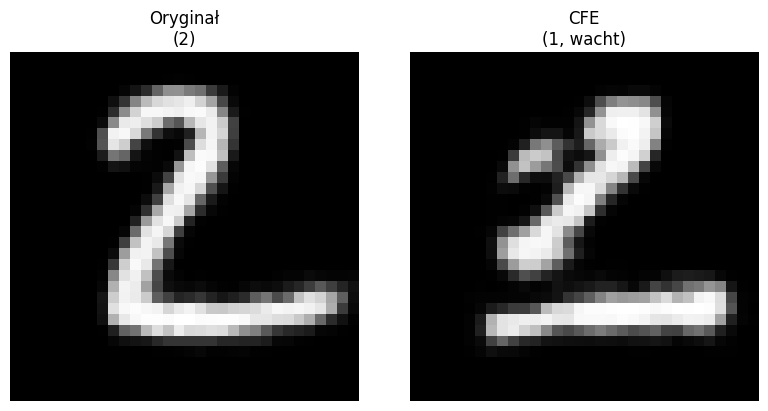

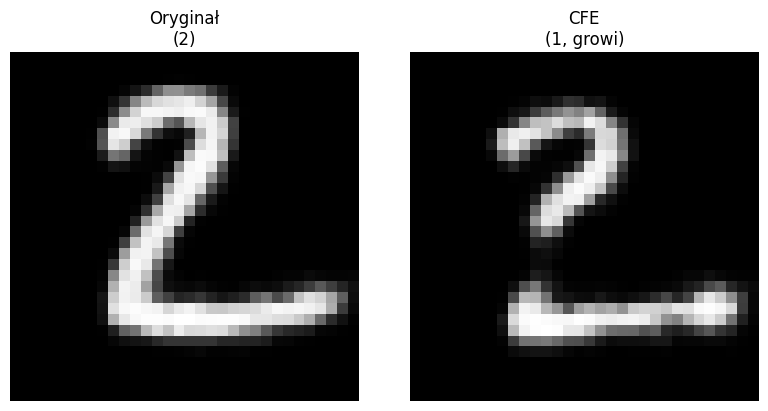

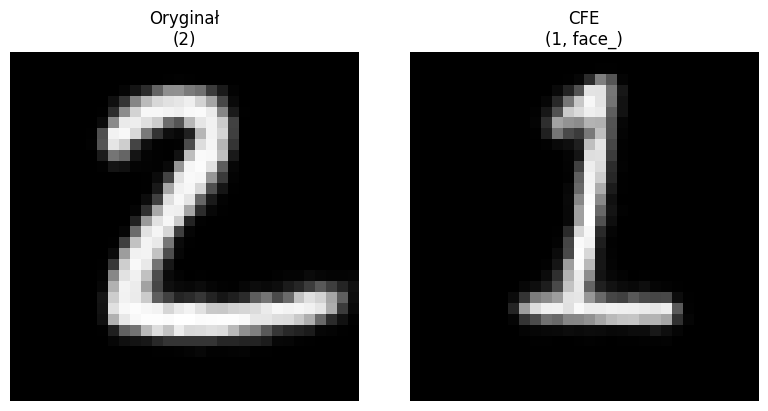

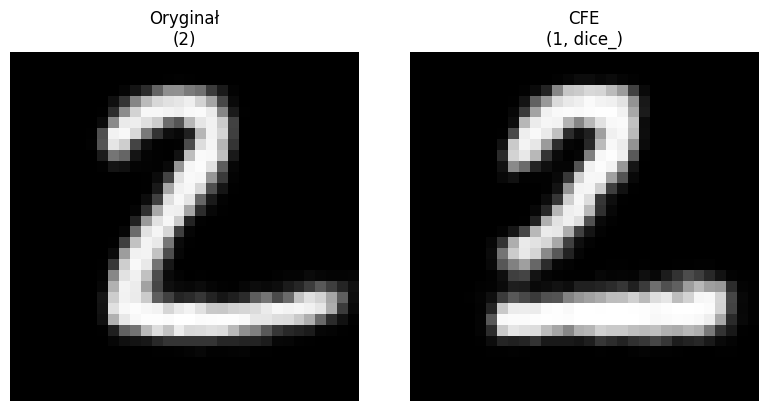

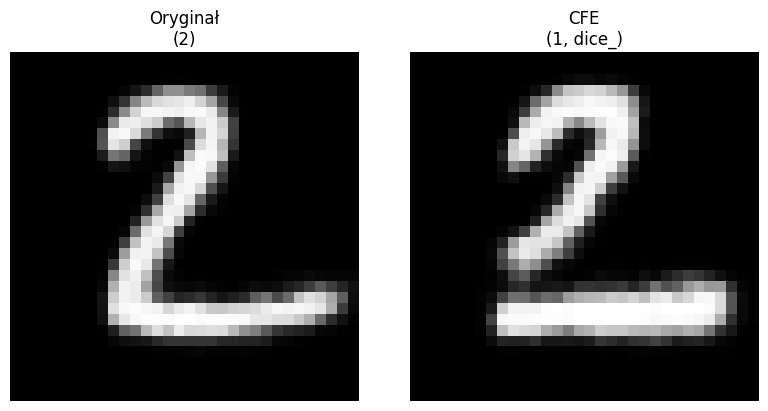

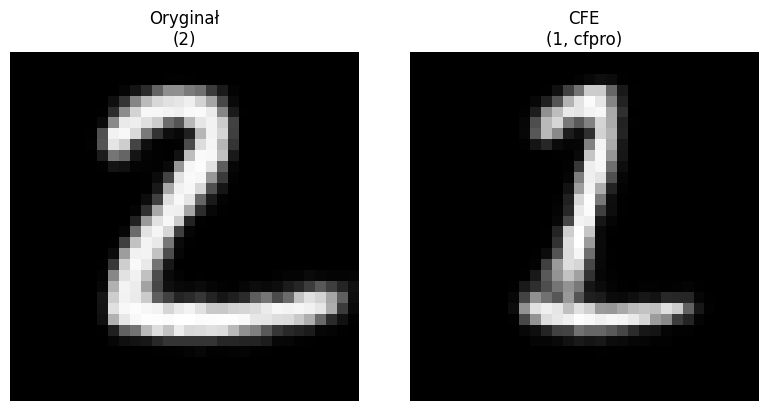

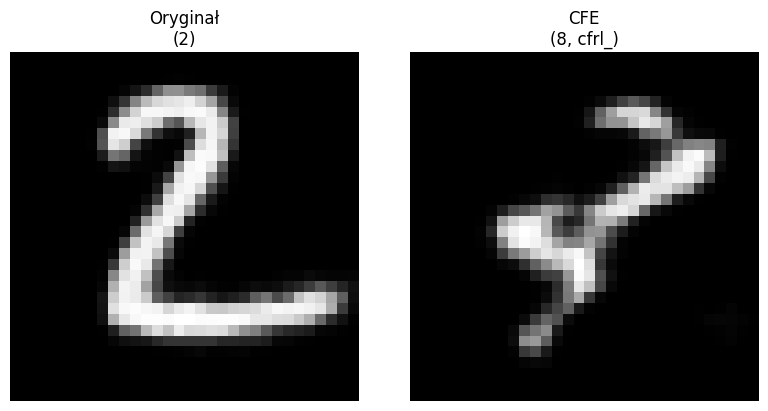

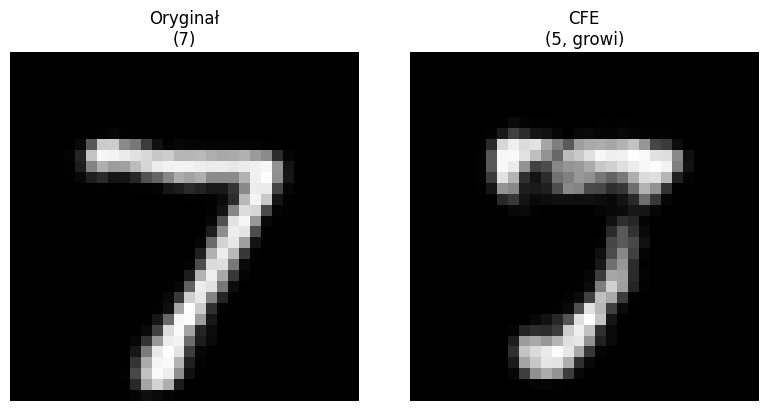

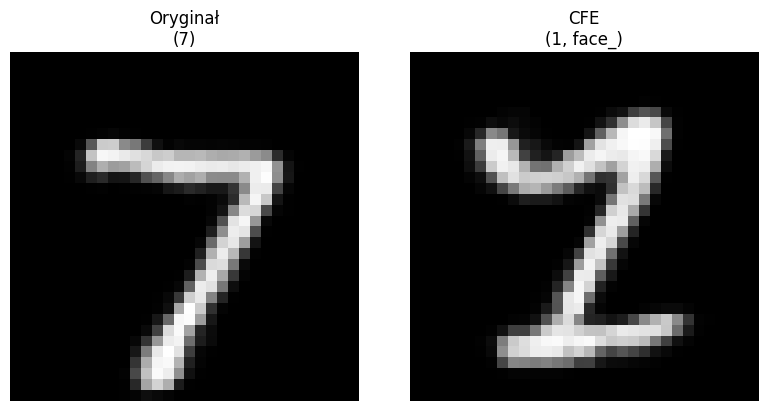

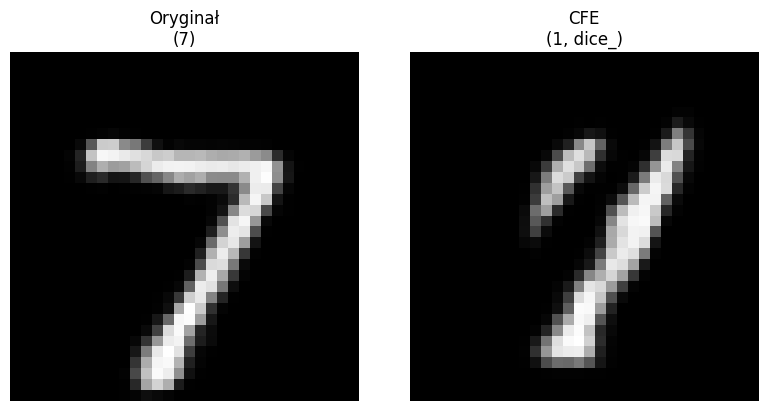

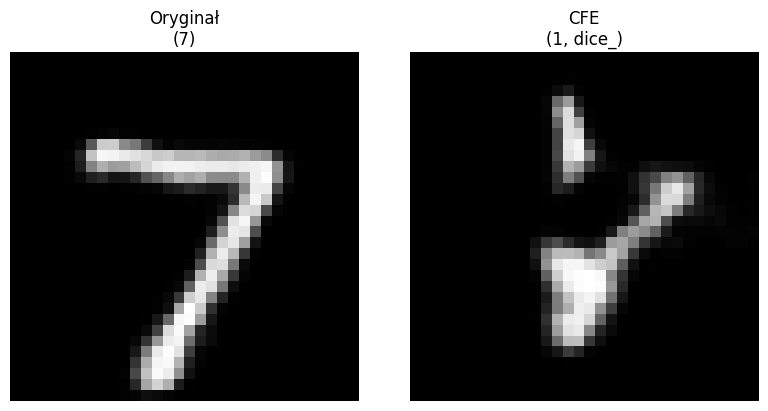

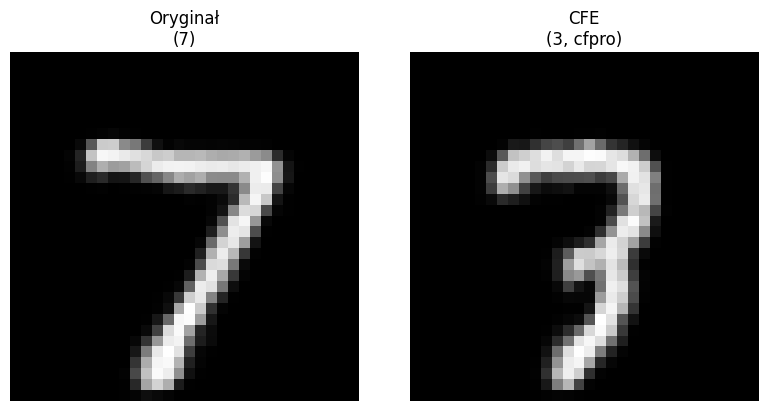

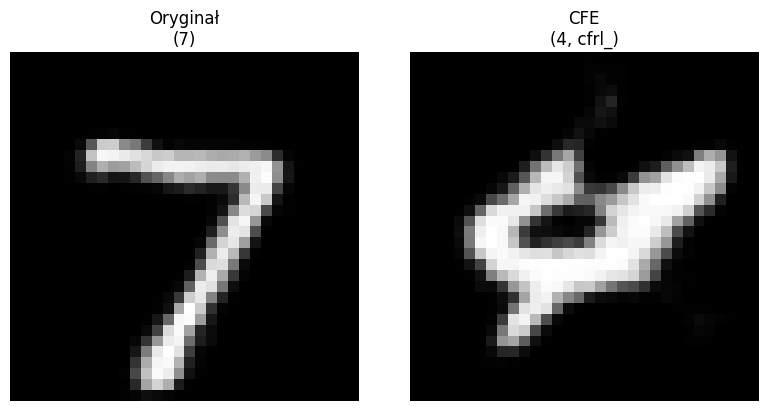

In [27]:
plot_cfes(cfes)
